Cài đặt Pytorch


In [ ]:
pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Kết nối google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Cài đặt thư viện, hiển thị dữ liệu**

Cài đặt các thư viện pytorch, GPU

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [4]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda')

Hiển thị, kiểm tra dữ liệu

In [6]:
path = '/content/gdrive/MyDrive/LSTM/data/'
base_csv = path + 'IMDB_Dataset.csv'
df = pd.read_csv(base_csv)
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [8]:
a = df['sentiment'].to_numpy()
np.unique(a)

array(['negative', 'positive'], dtype=object)

Tập dữ liệu gồm 50000 câu review về các bộ phim, có hai nhãn cho bình luận, là 'negative': nhãn bình luận tiêu cực và 'positive': nhãn bình luận tích cực.

Phân chia dữ liệu tỉ lệ dữ liệu huấn luyện : dữ liệu kiểm tra = 3:1

In [9]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print("Số lượng dữ liệu huấn luyện {}".format(x_train.shape))
print("Số lượng dữ liệu kiểm tra {}".format(x_test.shape))

Số lượng dữ liệu huấn luyện (37500,)
Số lượng dữ liệu kiểm tra (12500,)


Trong dữ liệu huấn luyện số lượng nhãn tích cực và số lượng nhãn tiêu cực xấp xỉ bằng nhau

In [10]:
np.unique(y_train, return_counts= True)

(array(['negative', 'positive'], dtype=object), array([18750, 18750]))

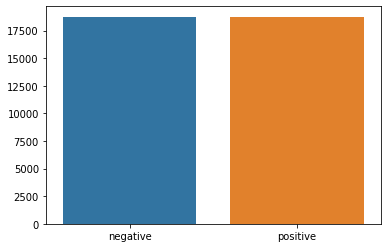

In [11]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

#**Tiền Xử Lý Dữ Liệu**

In [12]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

In [13]:
stopwords

<WordListCorpusReader in '.../corpora/stopwords' (not loaded yet)>

In [14]:
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = stop
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [16]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Từ điển, mã hoá câu trong file train và test

In [17]:
print(len(x_train))
print("Hiển thị dữ liệu huấn luyện sau khi mã hoá:", x_train[0:5])
print(len(y_train))
y_train
print(vocab)
print("Kích thước của từ điển:",len(vocab))

37500
Hiển thị dữ liệu huấn luyện sau khi mã hoá: [list([618, 823, 43, 54, 34, 222, 176, 324, 95, 1, 901, 542, 54, 145, 102, 3, 8, 461, 700, 7, 54, 46, 12, 178, 460, 1, 777, 1, 501, 373, 368, 253, 316, 131, 2, 49, 340, 296, 3, 1, 1, 202, 71, 118, 128, 68, 258, 446, 280, 68, 102, 1, 113, 73, 104, 843, 254, 60, 134, 305, 3, 729, 422, 104, 5, 255, 556, 675, 323, 695, 458, 260, 37, 55, 12, 8, 214, 5, 612, 222, 176, 102, 164, 737, 2, 804, 64, 71, 1, 595, 807, 98, 530, 302, 152, 7, 73, 556, 71, 101, 942, 513, 1, 16, 41, 932, 921, 330, 324, 321, 5, 23, 449, 38, 1, 79, 27, 248, 633, 12, 297, 546, 546, 366, 128, 27, 682, 324, 94, 686, 222, 176, 3, 10, 95, 32, 31, 19, 47, 8, 69, 164, 269, 247, 1, 115, 579, 62, 9, 85, 13, 75, 543, 783, 169, 314, 31, 763, 125, 102, 1, 356, 125, 256, 659, 788, 176, 54, 23, 175, 1, 583, 52, 95, 62, 30])
 list([385, 80, 669, 682, 26, 125, 38, 13, 922, 677, 204, 107, 110, 206, 86, 463, 844, 712, 589, 86, 917, 1, 308, 405, 835, 283, 31, 536, 658, 22, 37, 48, 36, 1, 147

Thống kê độ dài của một bình luận, trung bình, độ lệch chuẩn

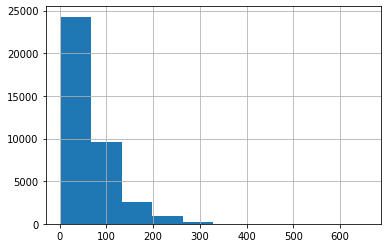

count    37500.000000
mean        69.572053
std         48.421766
min          3.000000
25%         39.000000
50%         54.000000
75%         85.000000
max        654.000000
dtype: float64

In [18]:
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

Trung bình độ dài của một bình luận là 69 từ, có những bình luận chỉ có 2 từ.

Quá trình Padding - chèn từng chuỗi để từng chuỗi có độ dài tối đa

In [19]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [20]:
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

In [21]:
print(x_train_pad[0:5])

[[  0   0   0 ...  95  62  30]
 [  0   0   0 ...  30  35   6]
 [  0   0   0 ... 788 109 656]
 [  0   0   0 ... 283 190   2]
 [  0   0   0 ...   8 100 257]]


Tải và chuyển dữ liệu dưới dạng Tensor Pytorch

In [22]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

Xét một batch_size = 50 khi sử dụng DataLoader

In [23]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ...,   3,  37,  71],
        [  0,   0,   0,  ...,   2, 899, 898],
        [  0,   0,   0,  ...,  54, 593, 392],
        ...,
        [  0,   0,   0,  ..., 615, 244,   3],
        [  0,   0,   0,  ..., 481,  11, 344],
        [  0,   0,   0,  ..., 379,  45, 133]])
Sample input: 
 tensor([0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 1])


#**Mô Hình LSTM trong Mạng Neuron Hồi Tiếp RNN**

Xây dựng class mô hình RNN
- output_dim : 
- hidden_dim : 
- no_layers:
- vocab_size: kích thước của từ điển 
- embedding: kích thước ma trận nhúng (từ điển, số chiều nhúng)
- lstm:

Quá trình forward



In [24]:
class SentimentRNN(nn.Module):
  def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
    
        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
  def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        # print("Embedim_shape:",embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
  def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden


In [25]:
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#moving to gpu
model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [26]:
# loss and optimization functions
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [27]:
clip = 5
epochs = 10
valid_loss_min = np.Inf
# train for some number of epochs
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    # initialize hidden state 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device) 
        # print("inputs:", inputs)
        # print("inputs shape:", inputs.shape)
        # print("labels:", labels)
        # print("labels shape:", labels.shape)

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])
        # print("h:", h)
        # print("h shape:", len(h))
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        # calculating accuracy
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/LSTM/state_dict.pt')
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
        valid_loss_min = epoch_val_loss
    print(25*'==')
    

Epoch 1
train_loss : 0.5181178936958313 val_loss : 0.4185748643279076
train_accuracy : 74.488 val_accuracy : 81.328
Validation loss decreased (inf --> 0.418575).  Saving model ...
Epoch 2
train_loss : 0.395133052666982 val_loss : 0.36387846946716307
train_accuracy : 82.768 val_accuracy : 83.896
Validation loss decreased (0.418575 --> 0.363878).  Saving model ...
Epoch 3
train_loss : 0.34185469542940455 val_loss : 0.3574662390947342
train_accuracy : 85.51466666666667 val_accuracy : 84.624
Validation loss decreased (0.363878 --> 0.357466).  Saving model ...
Epoch 4
train_loss : 0.31029180470108986 val_loss : 0.3493713532090187
train_accuracy : 86.74666666666667 val_accuracy : 84.63199999999999
Validation loss decreased (0.357466 --> 0.349371).  Saving model ...
Epoch 5
train_loss : 0.27950875266393027 val_loss : 0.34272393184900285
train_accuracy : 88.24533333333333 val_accuracy : 85.32
Validation loss decreased (0.349371 --> 0.342724).  Saving model ...
Epoch 6
train_loss : 0.2473613829

Qúa trình lan truyền tiến forward:
- Tensor đầu vào: [50, 500] trong đó 50 là batch_size và 500 độ dài mã hoá, label [50]
- Embedd(x): [1001, 64], nhúng tensor đầu [50, 500] được embedding là [50, 500, 64].
- Qua kiến trúc LSTM(x, hidden), đầu ra lstm_out = (bath_size = 50, squen_len= 500, hidden_dim = 256)
- View lại đầu ra lstm_out(25000, 256)
- Đi qua một lớp tuyến tính (hidden_dim =256, out_put_dim =1) được tensor (25000, 1), qua lớp sigmoid.
- View lại tensor(batch_size,-1): (50,500), đầu ra torch[50] chứa các vector xác suất của 50 câu.



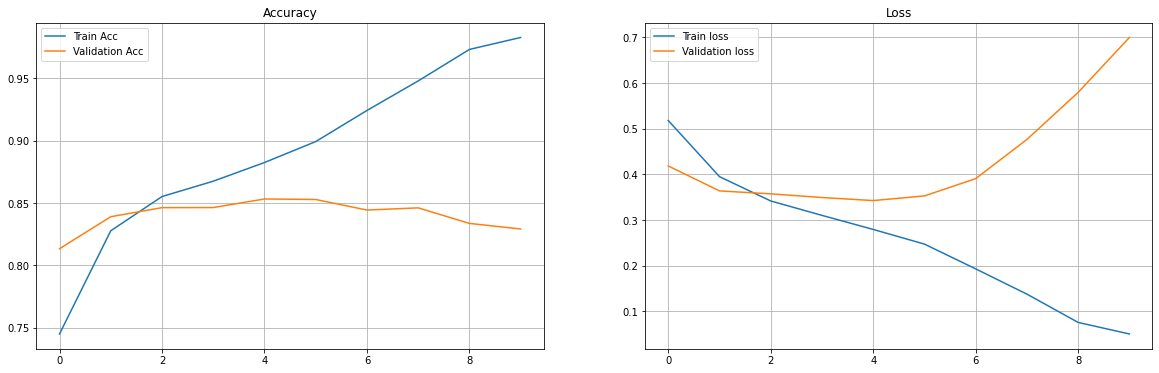

In [28]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()